
Reuse the FN433596 bam file.
Need to name the reference.fasta to ENA|FN433596|FN433596.1.fa


https://github.com/abyzovlab/CNVnator/wiki/Calling-CNVs

```
cnvnator -root out.root -tree FN433596.fasta.sorted.bam 

# GENERATING HISTOGRAM
cnvnator -root out.root -his 100 

#CALCULATING STATISTICS 
cnvnator -root out.root -stat 100

#RD SIGNAL PARTITIONING
cnvnator -root out.root -partition 100 -ngc

# CNV calling
cnvnator -root out.root -call 100 -ngc > events_bin100.txt

```

time = 26 + 6 + 1 + 13 + 20

Setting the binning to 1, the all analysis takes about 10 minutes.
```
cnvnator -root out.root -tree FN433596.fasta.sorted.bam 
cnvnator -root out.root -his 1
cnvnator -root out.root -stat 1
cnvnator -root out.root -partition 1 -ngc
cnvnator -root out.root -call 1 -ngc > events_bin1.txt
```

Took 35 minutes on TARS

- sequana coverage W=20000 takes 2 minutes with reports and conversion BAM to BED
- if BED present, W=20000 takes 59s
- if BED present, W=100000 takes 56s

In [25]:
from sequana import GenomeCov
%pylab inline
rcParams['figure.figsize'] = (10,7)
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


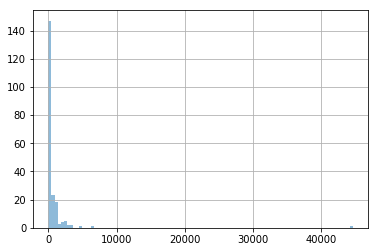

In [8]:
def get_events(filename):
    df1 = pd.read_csv(filename, sep="\t", header=None)
    df1 = df1[df1.columns[0:3]]
    df1.columns = ["type", "pos", "size"]
    df1['contig'] = df1["pos"].apply(lambda x: x.split(":")[0])
    df1['start'] = df1["pos"].apply(lambda x: int(x.split(":")[1].split("-")[0]))
    df1['end'] = df1["pos"].apply(lambda x: int(x.split(":")[1].split("-")[1]))
    return df1
df1 = get_events("events_bin1.txt")
df100 = get_events("events_bin100.txt")


df1['size'].hist( bins=100,alpha=0.5)

In [12]:
len(df1), len(df100)

(207, 13)

In [17]:
# load the BED and genbank file
b = GenomeCov("FN433596.fasta.sorted.bed")
chromosome = b.chr_list[0]
chromosome.run(20001, circular=True, cnv_delta=1000)
    
    
def plot_variant(chrom, x1=526000, x2=538000):
    clf()    
    chrom.plot_rois(x1, x2)
    roi = chrom.rois
    low = roi.get_low_rois()
    high = roi.get_high_rois()
    chr = chrom
    highT = (chr.thresholds.high * chr.best_gaussian["sigma"] +
         chr.best_gaussian["mu"]) * chr.df["rm"]
    lowT = (chr.thresholds.low * chr.best_gaussian["sigma"] +
        chr.best_gaussian["mu"]) * chr.df["rm"]

    if len(low):
        for k,v in low.iterrows():        
            Y1 = chr.df['cov'].loc[v.start:v.end]
            Y2 = lowT.loc[v.start:v.end] 
            Y1 = Y1.combine(Y2, max) *0
            if v.start > x1 and v.end<x2:
                try:fill_between(range(v.start, v.end+1), Y1, Y2, alpha=0.6, color="blue")
                except:pass
    
    if len(high):
        for k,v in high.iterrows():
            Y1 = highT.loc[v.start:v.end]
            Y2 = chr.df['cov'].loc[v.start:v.end]
            Y2 = Y2.combine(Y1,max)
            if v.start > x1 and v.end<x2:
                try:fill_between(range(v.start, v.end+1), y1=Y1,y2=Y2 ,alpha=0.6, color="orange")
                except:pass

    xlim([x1,x2])

    return chromosome

In [62]:
from easydev import Progress
cnvnator = df100
N = len(cnvnator)
pb = Progress(N)
for i in range(N):
    this = cnvnator.loc[i]
    chro = plot_variant(chromosome, max(this.start-10000, 0), this.end+10000)
    x1, x2 = xlim()
    L = x2-x1
    color = "yellow"
    axhline(chro.df['cov'].mean(), (this.start-x1)/L, (this.end-x1)/L, lw=5, color=color)
    savefig("comp_cnv_{}.png".format(i+1), dpi=200)
    pb.animate(i+1)
close()               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# conclusion

- the 13 events detected by cnvnator are also detected with sequana_coverage
- sequana_coverage detects additional events (see image below) 
  - very short (See e.G. image comp_cnv_2.png, position 380000)
  - medium size (see e.g. image comp_cnv_2.png, position 395000)
  - very short and strong events (e.g. comp_cnv_3, position 540000)
  - long (e.g. comp_cnv_12.png, position 2444242, event of 2163 bases)
- CNVnator is better at detected long events. For instance, in comp_cnv_10.png, the large gap is detected. Here with sequana_coverage we also detect it but the window paramter being short, we could have missed it. 

In [34]:
from IPython.display import Image, HTML

Event detected in CNVnator (red thick line) and sequana_coverage (green line). Note that there are other events detected with sequana_coverage: short (red and green dots), medium size event also at position 395000

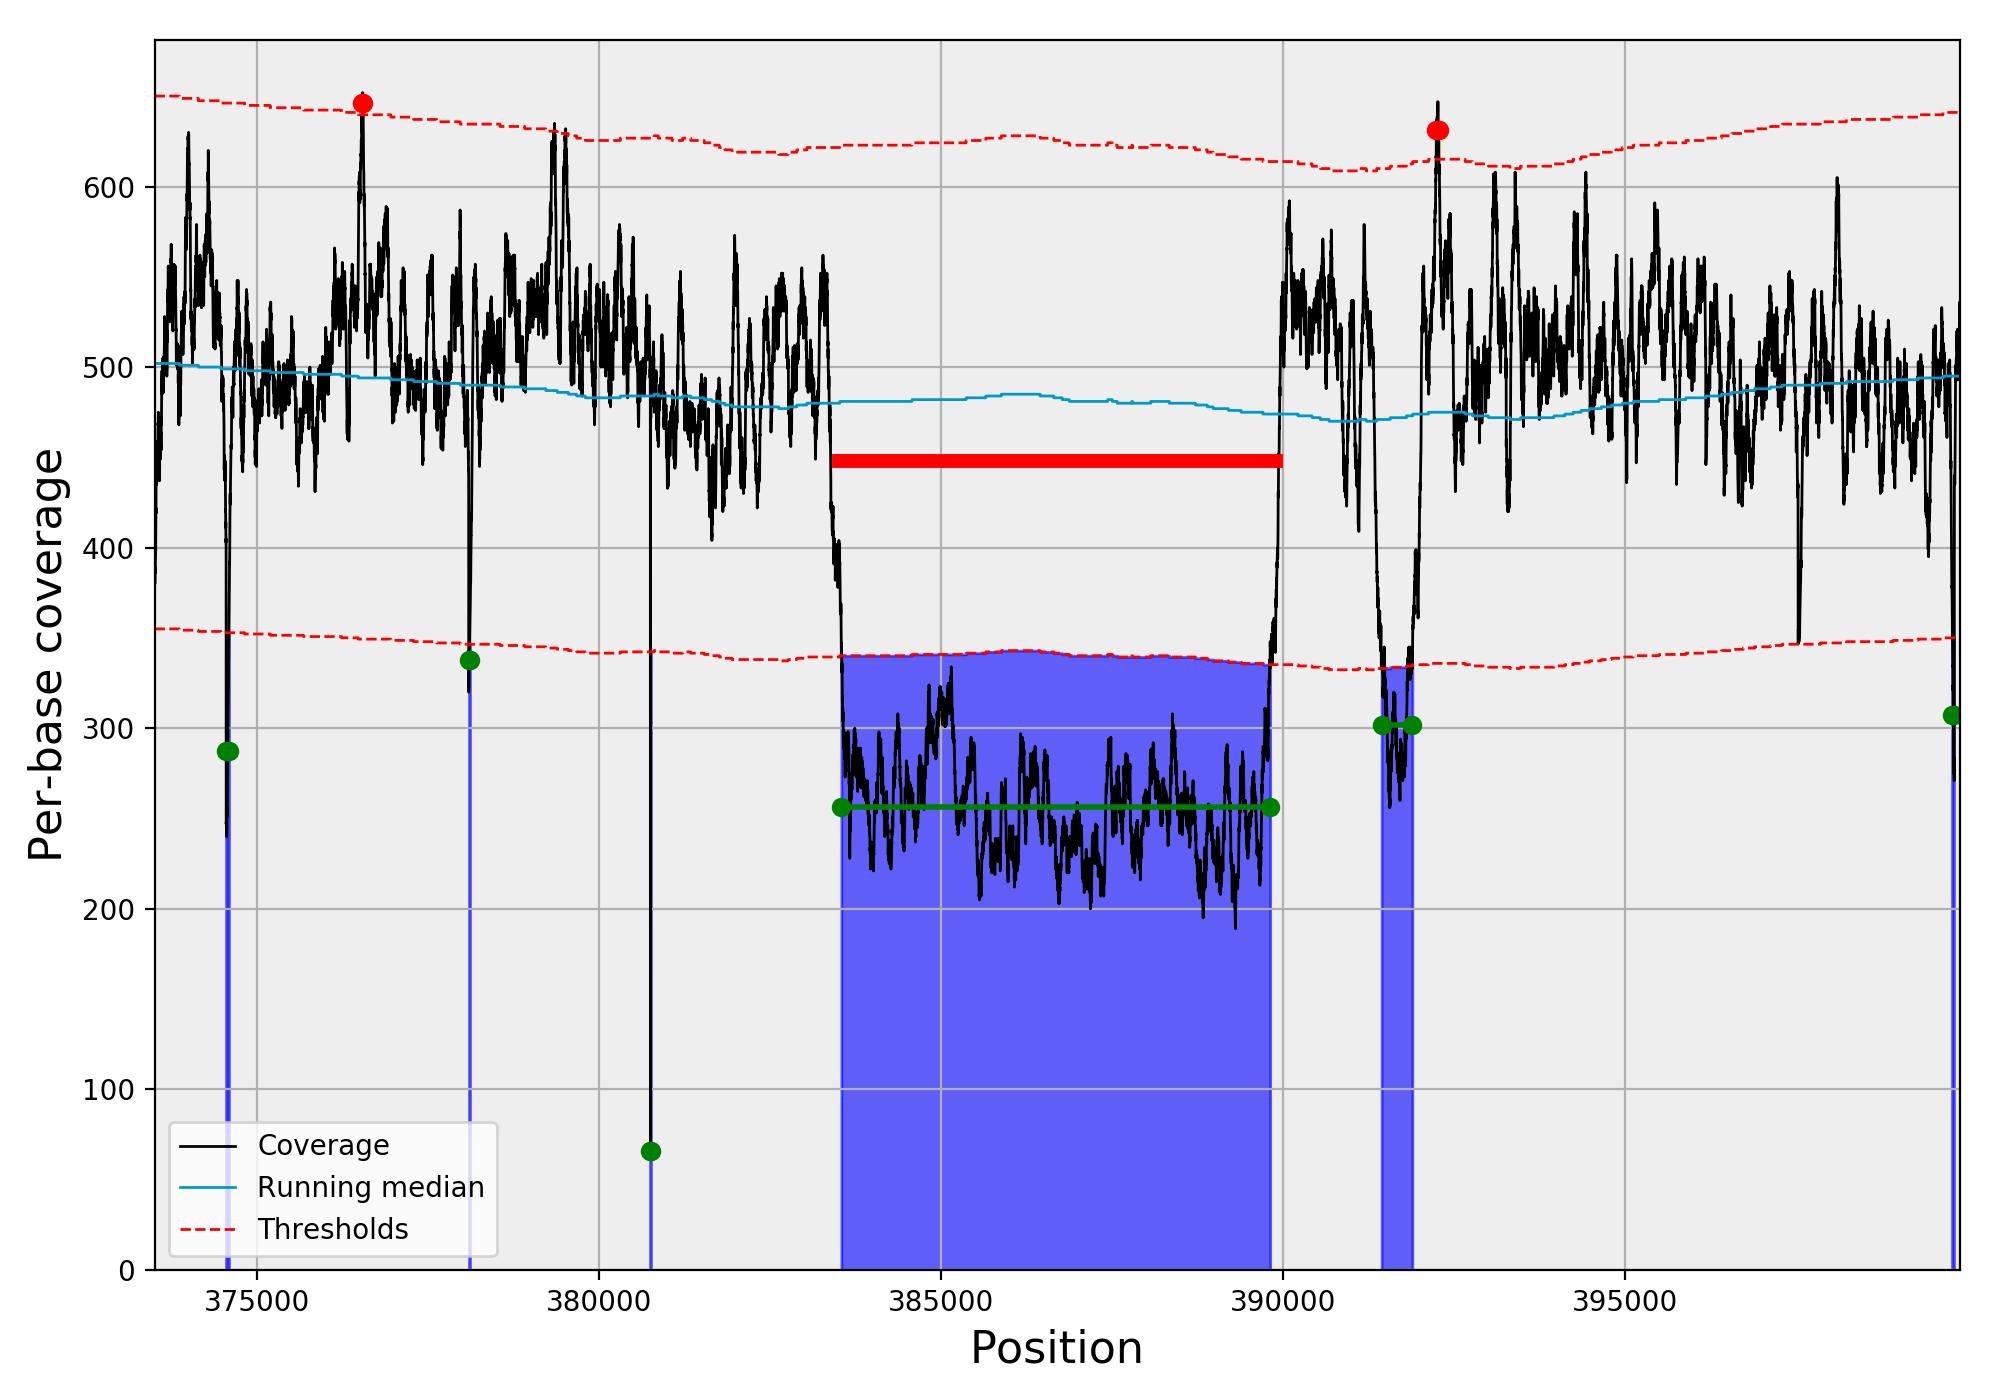

In [61]:
Image("comp_cnv_2.png", width="70%")

Strong and short events (right hand side) are detected by sequana_coverage (here as a single events because we clustered events with distances below 1000 bases)

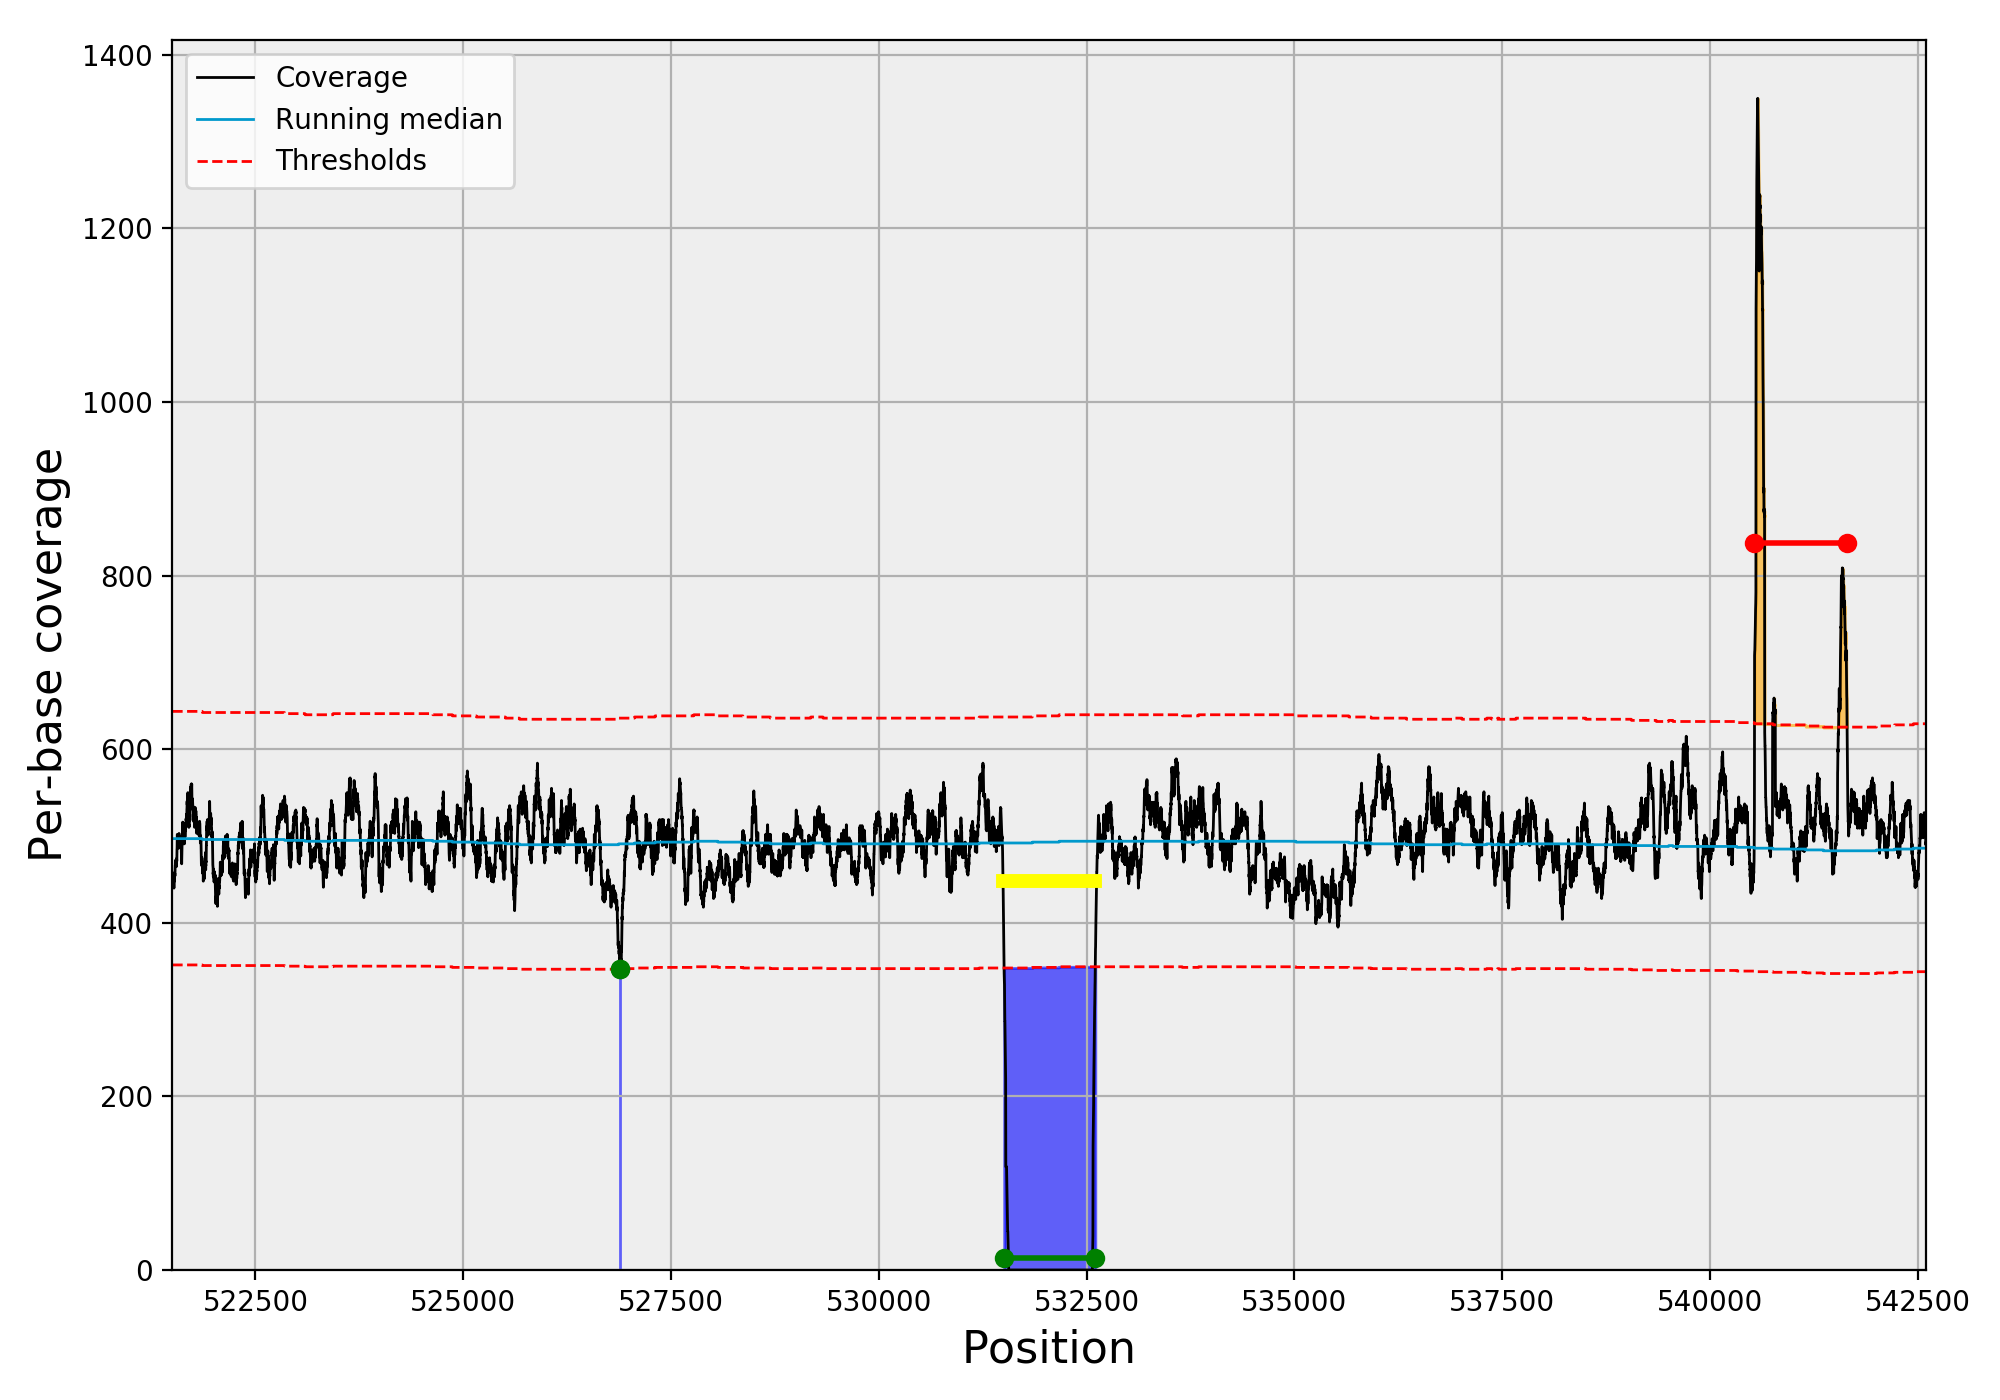

In [63]:
Image("comp_cnv_3.png", width="70%")

In [ ]:
Complex pattern such as the following ones are handled correctly in sequana_coverage: we detect 4 distincts long events.
CNVnator itself, find the first and last events only;

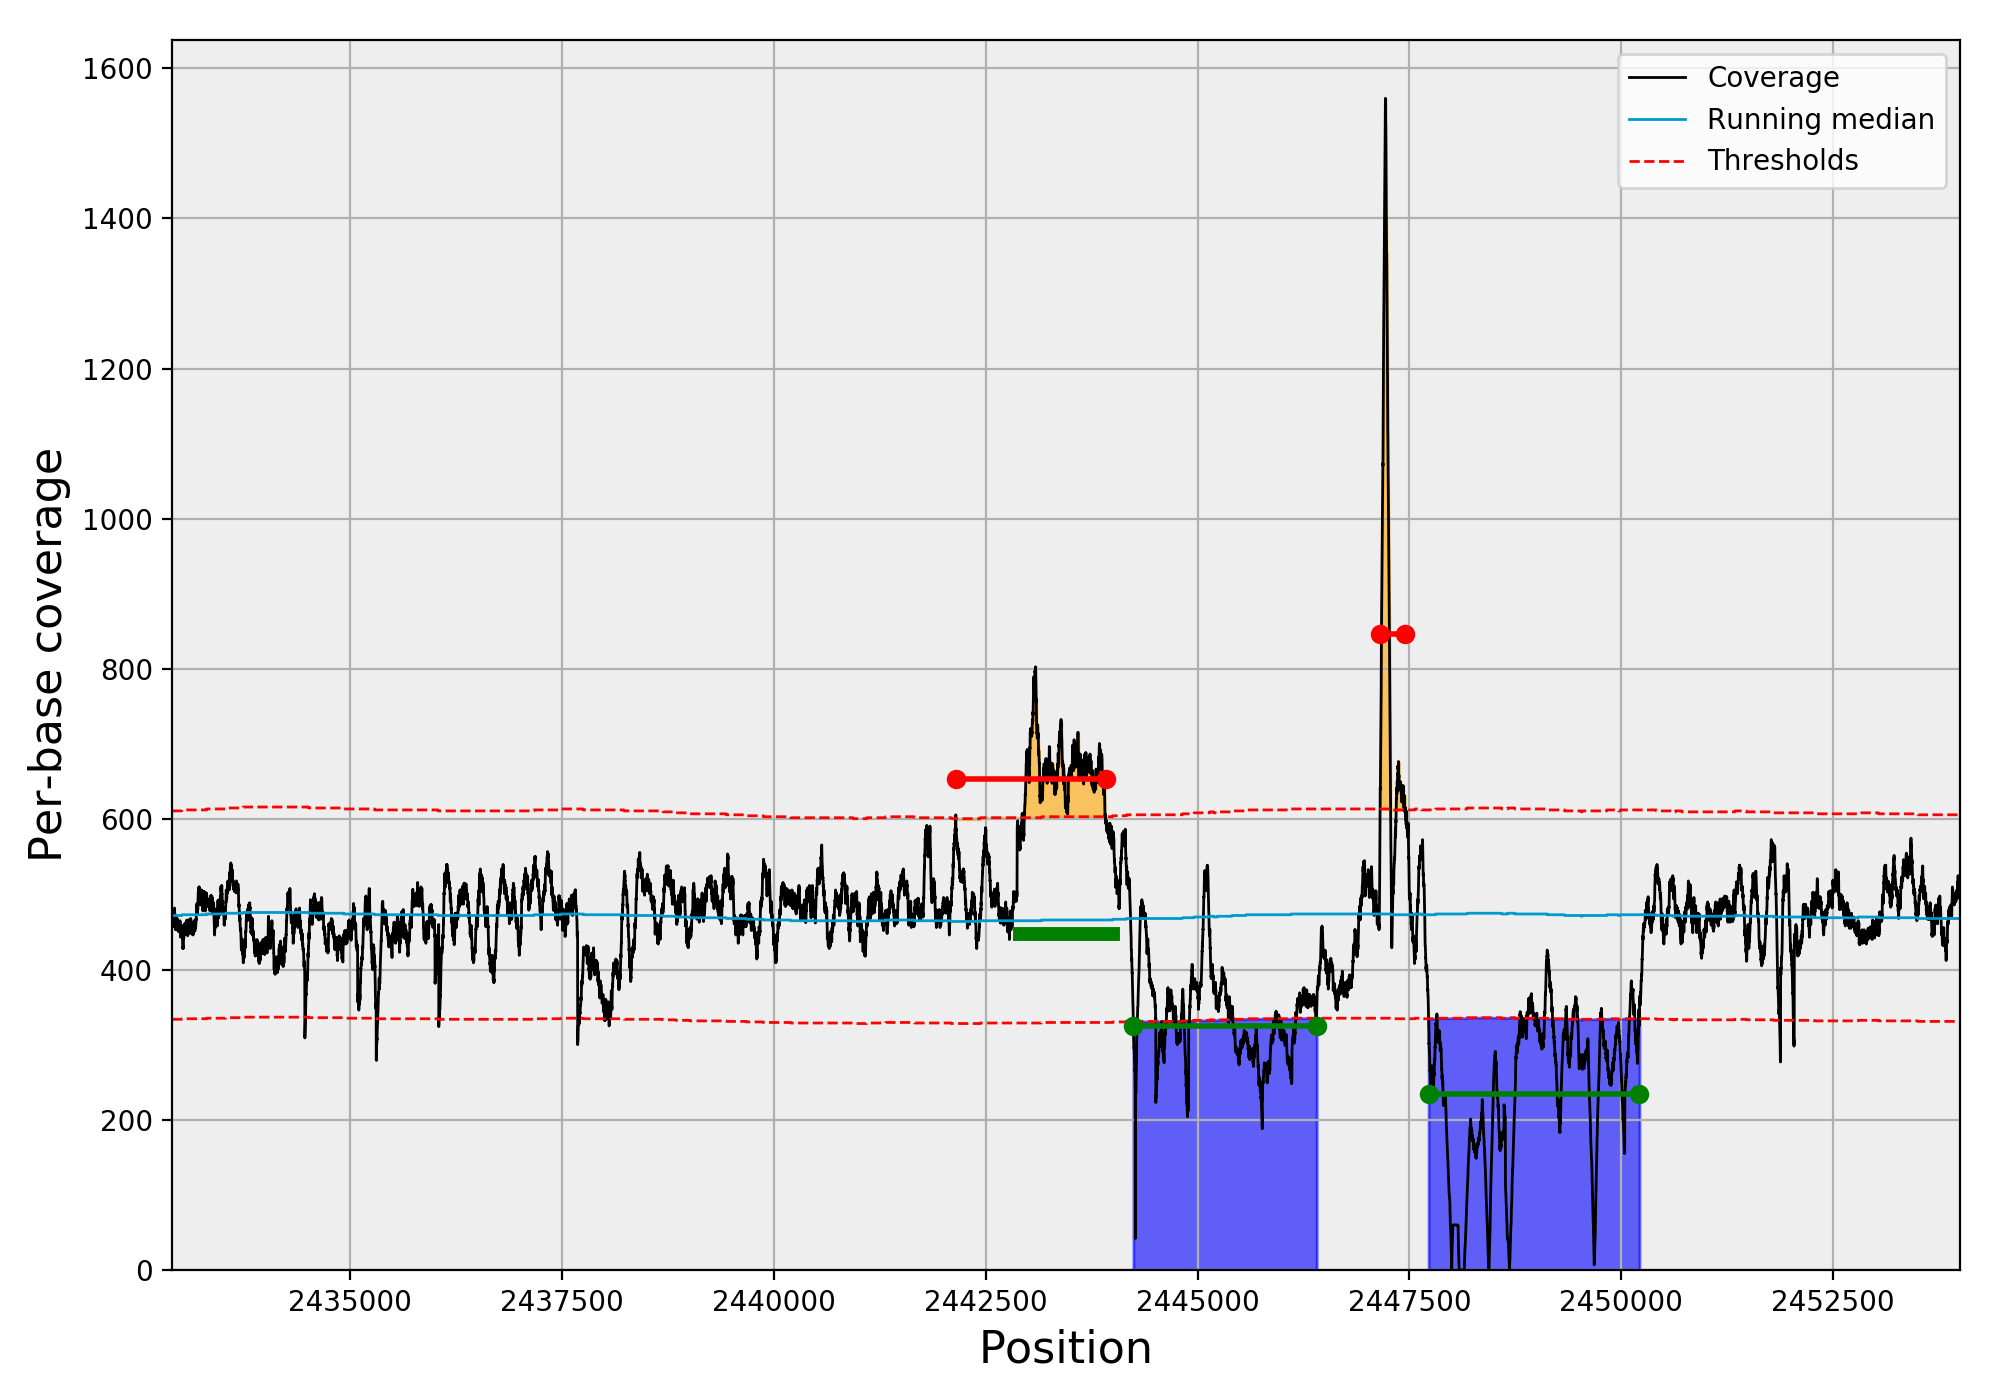

In [60]:
Image("comp_cnv_12.png", width="70%")


Event that could be missed by sequana_coverage. Here it is detected becase the average coverage is zero and such events are reported systematically.

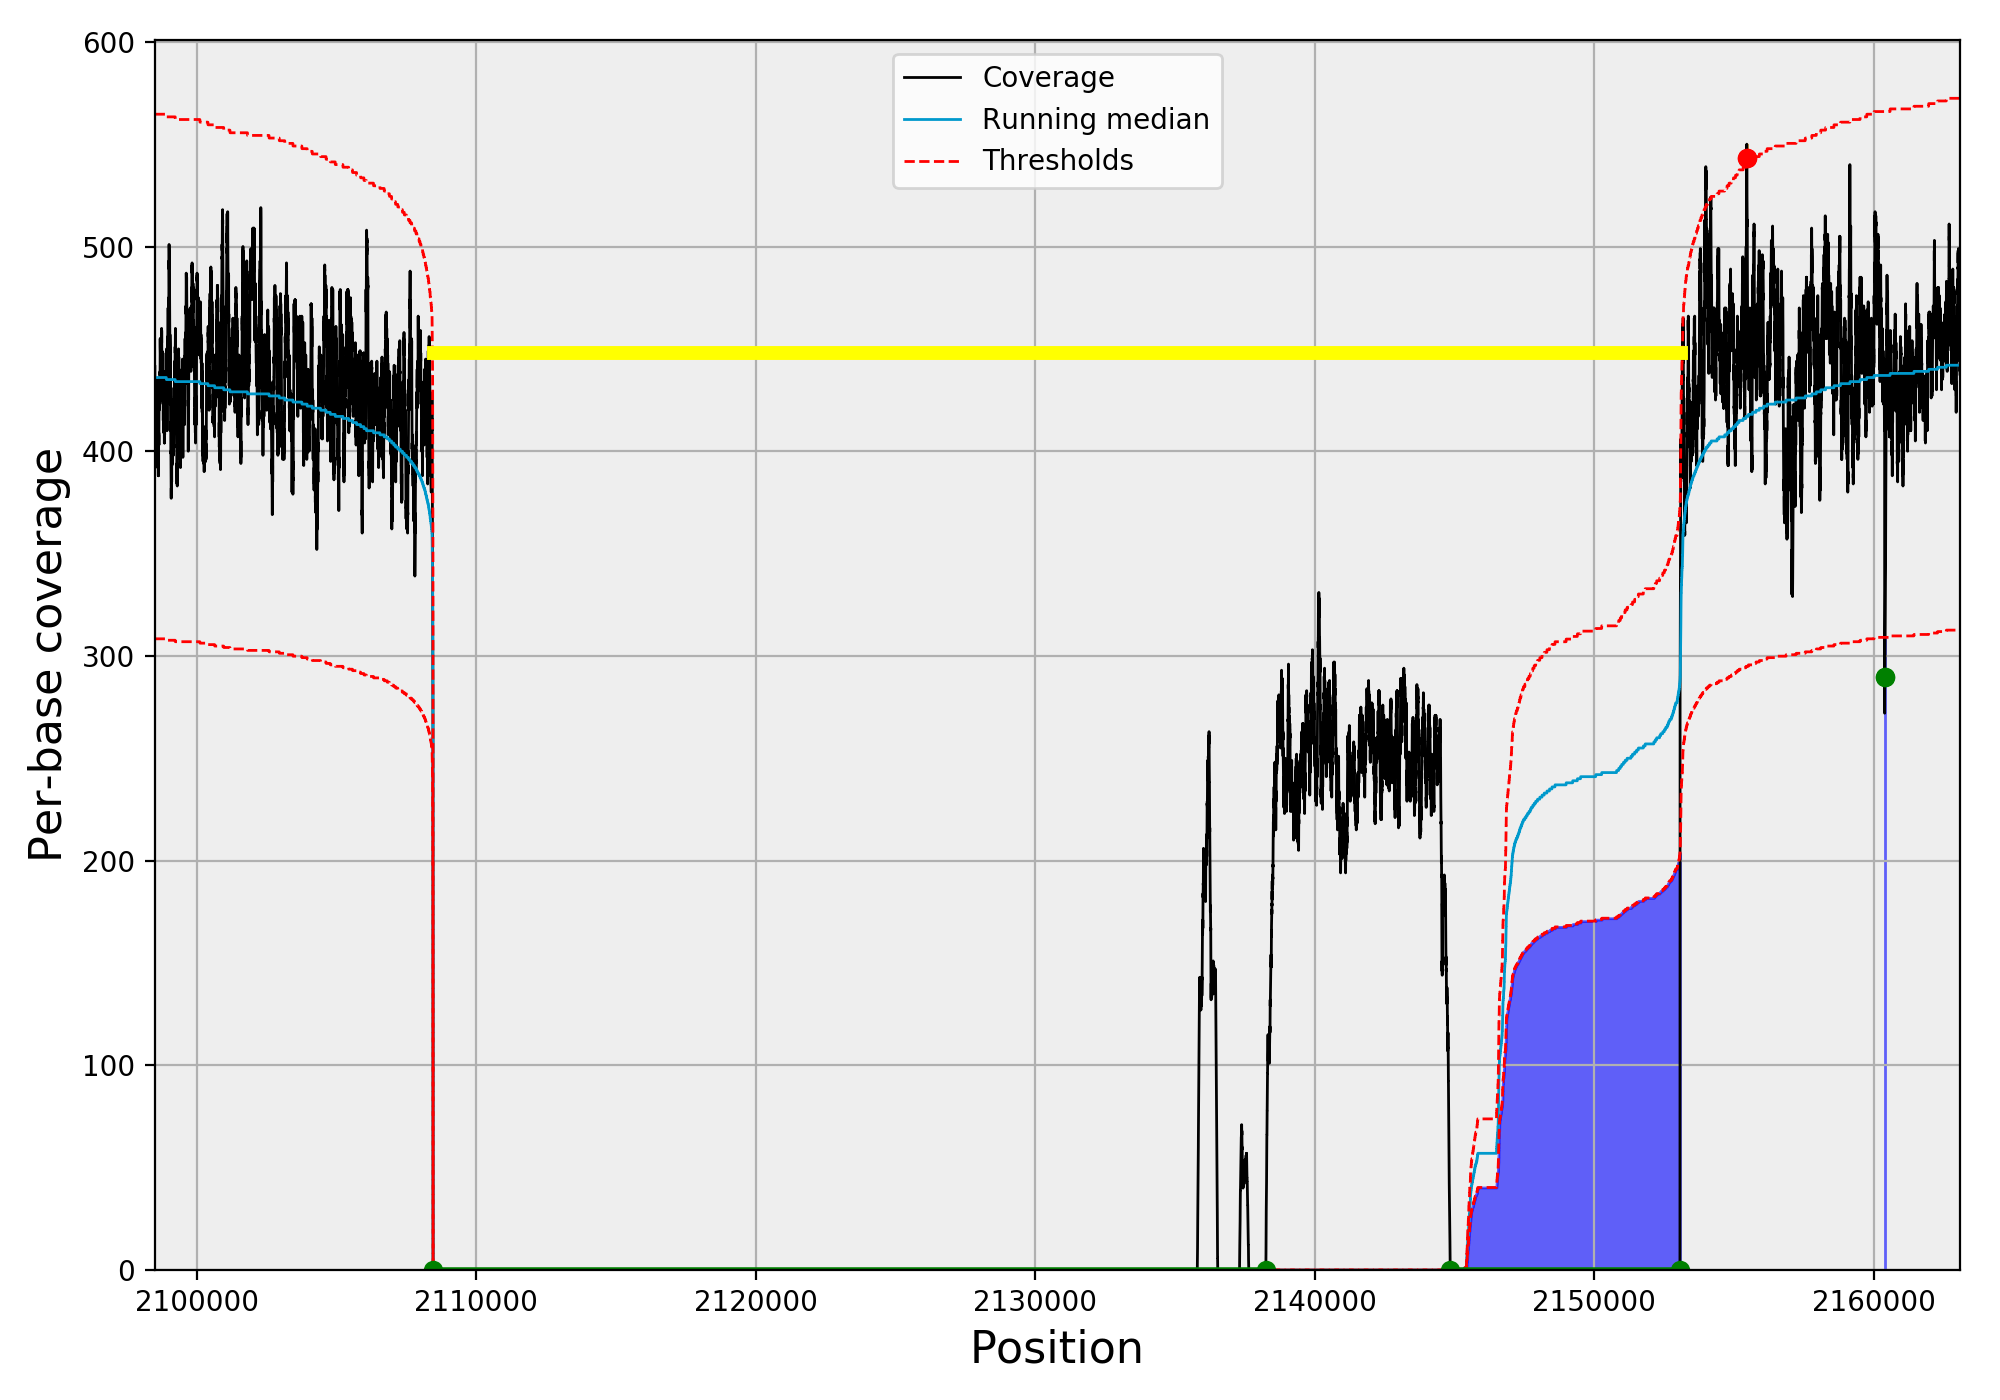

In [65]:
Image("comp_cnv_10.png", width="70%")
